In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results_v2/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. Trying to reduce it: v2. 255 Normalization. Weighted for Precision.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

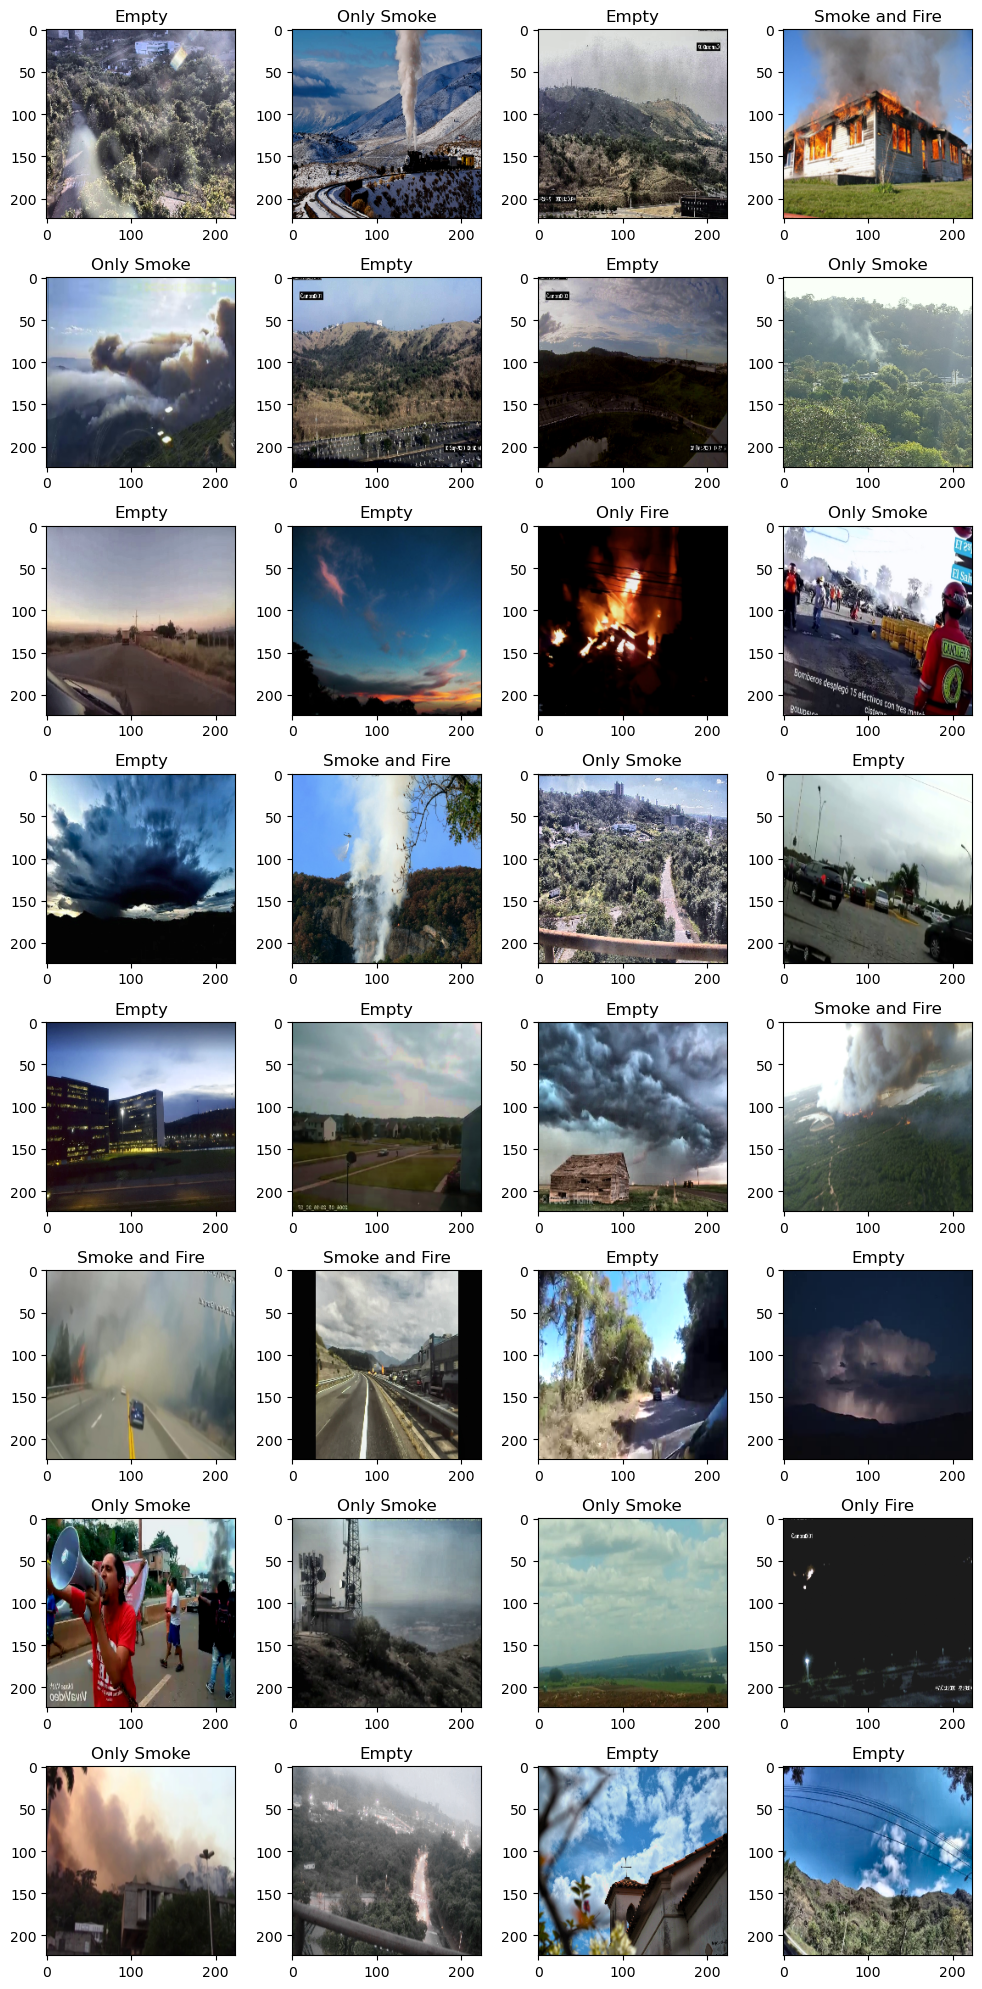

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 32
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             # CNNBlock 7x7
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(128, affine=False),
#             nn.ReLU(),
#             nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(self.last_channels, affine=False),
#             nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device, smoke_precision_weight):
        super(BCE_LOSS, self).__init__()
        self.smoke_precision_weight = smoke_precision_weight
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.pos_weight = torch.tensor([self.smoke_precision_weight]).to(self.device)
        self.bce_smoke = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.pos_weight)
        self.bce_fire = nn.BCEWithLogitsLoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce_smoke(predictions[..., 0],
                                    ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce_fire(predictions[..., 1],
                                  ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
EPOCHS = 125 #100
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"

LOSS_FN = "BCE"
SMOKE_PRECISION_WEIGHT = 0.7

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [17]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[ 0.3094, -0.1246],
        [ 0.3176, -0.2119],
        [ 0.2379, -0.1267],
        [ 0.4305, -0.4801]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mome

# Main Function

In [18]:
def main(model):

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        print(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        logger.info(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        loss_fn = BCE_LOSS(device=DEVICE, smoke_precision_weight=SMOKE_PRECISION_WEIGHT)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = torch.tensor([0.])
    smoke_f1_min_save = torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < v_pre[0].detach().to('cpu') ) and ( v_f1[0].detach().to('cpu') > smoke_f1_min_save ) :
            best_smoke_precision = v_pre[0].detach().to('cpu')
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_trained = main(model=model)

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE
Smoke Precision Weight: 0.7

***Start Training: 22:53:35

Initializing Weights

=== EPOCH 0/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
66.925      |36.495      |30.430      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.434      |35.796      |22.638      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.708 - Recall: 0.652 - Accuracy: 0.840 - F1: 0.679

Saving model with new best validation loss: 58.434

=== EPOCH 1/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.178      |35.550      |23.628      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.610      |35.185      |20.426      

SMOKE -> Precision: 0.729 - Recall: 0.140 - Accuracy: 0.561 - F1: 0.234
FIRE -> Precision: 0.811 - Recall: 0.673 - Accuracy: 0.875 - F1: 0.736

Saving model with new best validation loss: 55.610

=== EPOCH 2/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.247      |34.961      |21.286      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.584      |34.267      |18.317      

SMOKE -> Precision: 0.688 - Recall: 0.325 - Accuracy: 0.604 - F1: 0.441
FIRE -> Precision: 0.784 - Recall: 0.783 - Accuracy: 0.888 - F1: 0.783

Saving model with new best validation loss: 52.584

=== EPOCH 3/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.073      |34.486      |19.587      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.101      |33.934      |16.167      

SMOKE -> Precision: 0.716 - Recall: 0.372 - Accuracy: 0.627 - F1: 0.490
FIRE -> Precision: 0.810 - Recall: 0.816 - Accuracy: 0.903 - F1: 0.813

Saving model with new best validation loss: 50.101

=== EPOCH 4/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.726      |33.990      |18.736      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.357      |32.574      |15.783      

SMOKE -> Precision: 0.828 - Recall: 0.317 - Accuracy: 0.640 - F1: 0.459
FIRE -> Precision: 0.806 - Recall: 0.817 - Accuracy: 0.902 - F1: 0.812

Saving model with new best validation loss: 48.357

=== EPOCH 5/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.927      |33.122      |17.805      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.866      |31.732      |15.135      

SMOKE -> Precision: 0.813 - Recall: 0.322 - Accuracy: 0.638 - F1: 0.462
FIRE -> Precision: 0.831 - Recall: 0.829 - Accuracy: 0.912 - F1: 0.830

Saving model with new best validation loss: 46.866

=== EPOCH 6/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.842      |32.550      |17.292      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.931      |30.894      |14.038      

SMOKE -> Precision: 0.803 - Recall: 0.420 - Accuracy: 0.671 - F1: 0.551
FIRE -> Precision: 0.844 - Recall: 0.842 - Accuracy: 0.919 - F1: 0.843

Saving model with new best validation loss: 44.931

=== EPOCH 7/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.364      |31.828      |16.536      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.597      |30.302      |13.295      

SMOKE -> Precision: 0.783 - Recall: 0.529 - Accuracy: 0.703 - F1: 0.631
FIRE -> Precision: 0.851 - Recall: 0.861 - Accuracy: 0.925 - F1: 0.856

Saving model with new best validation loss: 43.597

=== EPOCH 8/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.561      |31.387      |16.174      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.872      |29.540      |13.332      

SMOKE -> Precision: 0.811 - Recall: 0.497 - Accuracy: 0.702 - F1: 0.616
FIRE -> Precision: 0.836 - Recall: 0.864 - Accuracy: 0.921 - F1: 0.850

Saving model with new best validation loss: 42.872

=== EPOCH 9/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.622      |30.946      |15.676      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.263      |28.652      |12.611      

SMOKE -> Precision: 0.810 - Recall: 0.533 - Accuracy: 0.715 - F1: 0.643
FIRE -> Precision: 0.877 - Recall: 0.839 - Accuracy: 0.928 - F1: 0.857

Saving model with new best validation loss: 41.263

=== EPOCH 10/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.158      |30.562      |15.596      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.322      |28.118      |12.205      

SMOKE -> Precision: 0.786 - Recall: 0.636 - Accuracy: 0.741 - F1: 0.703
FIRE -> Precision: 0.868 - Recall: 0.857 - Accuracy: 0.929 - F1: 0.863

Saving model with new best validation loss: 40.322

=== EPOCH 11/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.023      |29.966      |15.057      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.639      |27.286      |12.354      

SMOKE -> Precision: 0.807 - Recall: 0.545 - Accuracy: 0.719 - F1: 0.651
FIRE -> Precision: 0.870 - Recall: 0.851 - Accuracy: 0.929 - F1: 0.861

Saving model with new best validation loss: 39.639

=== EPOCH 12/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.331      |29.608      |14.723      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.915      |27.035      |11.880      

SMOKE -> Precision: 0.818 - Recall: 0.590 - Accuracy: 0.740 - F1: 0.686
FIRE -> Precision: 0.902 - Recall: 0.823 - Accuracy: 0.931 - F1: 0.861

Saving model with new best validation loss: 38.915

=== EPOCH 13/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.839      |29.436      |14.403      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.115      |27.341      |11.774      

SMOKE -> Precision: 0.749 - Recall: 0.732 - Accuracy: 0.753 - F1: 0.740
FIRE -> Precision: 0.866 - Recall: 0.862 - Accuracy: 0.930 - F1: 0.864

=== EPOCH 14/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.238      |29.016      |14.222      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.455      |26.521      |11.934      

SMOKE -> Precision: 0.837 - Recall: 0.571 - Accuracy: 0.740 - F1: 0.679
FIRE -> Precision: 0.897 - Recall: 0.818 - Accuracy: 0.929 - F1: 0.856

Saving model with new best validation loss: 38.455

=== EPOCH 15/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.665      |28.677      |13.988      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.473      |26.535      |10.939      

SMOKE -> Precision: 0.809 - Recall: 0.564 - Accuracy: 0.726 - F1: 0.664
FIRE -> Precision: 0.855 - Recall: 0.893 - Accuracy: 0.933 - F1: 0.874

Saving model with new best validation loss: 37.473

=== EPOCH 16/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.096      |28.386      |13.711      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.005      |25.855      |11.151      

SMOKE -> Precision: 0.826 - Recall: 0.561 - Accuracy: 0.732 - F1: 0.668
FIRE -> Precision: 0.838 - Recall: 0.906 - Accuracy: 0.930 - F1: 0.871

Saving model with new best validation loss: 37.005

=== EPOCH 17/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.865      |27.899      |13.965      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.944      |25.929      |11.014      

SMOKE -> Precision: 0.777 - Recall: 0.744 - Accuracy: 0.774 - F1: 0.760
FIRE -> Precision: 0.866 - Recall: 0.895 - Accuracy: 0.937 - F1: 0.880

Saving model with new best validation loss: 36.944

=== EPOCH 18/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.982      |27.899      |13.083      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.451      |24.699      |10.752      

SMOKE -> Precision: 0.810 - Recall: 0.721 - Accuracy: 0.785 - F1: 0.763
FIRE -> Precision: 0.913 - Recall: 0.831 - Accuracy: 0.936 - F1: 0.870

Saving model with new best validation loss: 35.451

=== EPOCH 19/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.767      |27.766      |13.000      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.869      |24.864      |11.005      

SMOKE -> Precision: 0.826 - Recall: 0.647 - Accuracy: 0.765 - F1: 0.726
FIRE -> Precision: 0.864 - Recall: 0.896 - Accuracy: 0.937 - F1: 0.880

=== EPOCH 20/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.361      |27.434      |12.927      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.250      |24.469      |10.781      

SMOKE -> Precision: 0.799 - Recall: 0.748 - Accuracy: 0.788 - F1: 0.772
FIRE -> Precision: 0.862 - Recall: 0.898 - Accuracy: 0.937 - F1: 0.880

Saving model with new best validation loss: 35.250

=== EPOCH 21/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.338      |27.253      |13.084      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.996      |23.844      |10.153      

SMOKE -> Precision: 0.849 - Recall: 0.648 - Accuracy: 0.775 - F1: 0.735
FIRE -> Precision: 0.895 - Recall: 0.872 - Accuracy: 0.940 - F1: 0.883

Saving model with new best validation loss: 33.996

=== EPOCH 22/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.313      |27.241      |13.072      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.122      |24.229      |10.893      

SMOKE -> Precision: 0.870 - Recall: 0.569 - Accuracy: 0.751 - F1: 0.688
FIRE -> Precision: 0.938 - Recall: 0.814 - Accuracy: 0.938 - F1: 0.871

=== EPOCH 23/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.491      |26.746      |12.745      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.221      |23.281      |10.940      

SMOKE -> Precision: 0.842 - Recall: 0.705 - Accuracy: 0.794 - F1: 0.767
FIRE -> Precision: 0.941 - Recall: 0.816 - Accuracy: 0.939 - F1: 0.874

=== EPOCH 24/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.006      |26.468      |12.538      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.489      |23.300      |10.189      

SMOKE -> Precision: 0.801 - Recall: 0.820 - Accuracy: 0.815 - F1: 0.810
FIRE -> Precision: 0.864 - Recall: 0.910 - Accuracy: 0.940 - F1: 0.886

Saving model with new best validation loss: 33.489

=== EPOCH 25/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.708      |26.264      |12.444      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.039      |22.251      |9.788       

SMOKE -> Precision: 0.855 - Recall: 0.680 - Accuracy: 0.791 - F1: 0.758
FIRE -> Precision: 0.911 - Recall: 0.877 - Accuracy: 0.946 - F1: 0.893

Saving model with new best validation loss: 32.039

=== EPOCH 26/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.797      |26.082      |12.715      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.807      |22.603      |10.204      

SMOKE -> Precision: 0.842 - Recall: 0.718 - Accuracy: 0.799 - F1: 0.775
FIRE -> Precision: 0.894 - Recall: 0.886 - Accuracy: 0.943 - F1: 0.890

=== EPOCH 27/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.484      |25.826      |12.658      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.444      |22.284      |10.159      

SMOKE -> Precision: 0.843 - Recall: 0.727 - Accuracy: 0.803 - F1: 0.781
FIRE -> Precision: 0.887 - Recall: 0.884 - Accuracy: 0.941 - F1: 0.885

=== EPOCH 28/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.092      |25.821      |12.272      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.258      |22.572      |9.686       

SMOKE -> Precision: 0.858 - Recall: 0.659 - Accuracy: 0.784 - F1: 0.745
FIRE -> Precision: 0.896 - Recall: 0.885 - Accuracy: 0.944 - F1: 0.890

=== EPOCH 29/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.907      |24.951      |11.955      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.680      |21.316      |10.364      

SMOKE -> Precision: 0.876 - Recall: 0.707 - Accuracy: 0.811 - F1: 0.783
FIRE -> Precision: 0.934 - Recall: 0.821 - Accuracy: 0.939 - F1: 0.874

Saving model with new best validation loss: 31.680

=== EPOCH 30/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.974      |24.990      |11.984      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.741      |21.401      |9.341       

SMOKE -> Precision: 0.850 - Recall: 0.742 - Accuracy: 0.813 - F1: 0.792
FIRE -> Precision: 0.896 - Recall: 0.889 - Accuracy: 0.945 - F1: 0.893

Saving model with new best validation loss: 30.741

=== EPOCH 31/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.034      |25.331      |11.702      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.868      |20.717      |9.151       

SMOKE -> Precision: 0.860 - Recall: 0.758 - Accuracy: 0.824 - F1: 0.805
FIRE -> Precision: 0.909 - Recall: 0.897 - Accuracy: 0.950 - F1: 0.903

Saving model with new best validation loss: 29.868

=== EPOCH 32/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.408      |24.779      |11.630      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.048      |21.337      |9.711       

SMOKE -> Precision: 0.848 - Recall: 0.749 - Accuracy: 0.814 - F1: 0.795
FIRE -> Precision: 0.939 - Recall: 0.849 - Accuracy: 0.947 - F1: 0.892

=== EPOCH 33/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.211      |24.677      |11.533      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.107      |21.006      |9.101       

SMOKE -> Precision: 0.853 - Recall: 0.762 - Accuracy: 0.823 - F1: 0.805
FIRE -> Precision: 0.925 - Recall: 0.883 - Accuracy: 0.951 - F1: 0.903

=== EPOCH 34/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.014      |24.487      |11.527      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.715      |21.714      |10.001      

SMOKE -> Precision: 0.878 - Recall: 0.641 - Accuracy: 0.785 - F1: 0.741
FIRE -> Precision: 0.937 - Recall: 0.835 - Accuracy: 0.943 - F1: 0.883

=== EPOCH 35/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.420      |24.033      |11.388      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.976      |20.767      |9.208       

SMOKE -> Precision: 0.855 - Recall: 0.749 - Accuracy: 0.818 - F1: 0.798
FIRE -> Precision: 0.919 - Recall: 0.879 - Accuracy: 0.949 - F1: 0.899

=== EPOCH 36/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.149      |23.796      |11.353      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.638      |20.098      |9.539       

SMOKE -> Precision: 0.858 - Recall: 0.796 - Accuracy: 0.839 - F1: 0.826
FIRE -> Precision: 0.933 - Recall: 0.869 - Accuracy: 0.950 - F1: 0.900

Saving model with new best validation loss: 29.638

=== EPOCH 37/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.959      |23.672      |11.288      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.755      |20.515      |9.240       

SMOKE -> Precision: 0.827 - Recall: 0.810 - Accuracy: 0.827 - F1: 0.819
FIRE -> Precision: 0.881 - Recall: 0.916 - Accuracy: 0.946 - F1: 0.898

=== EPOCH 38/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.987      |23.742      |11.245      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.934      |19.890      |9.044       

SMOKE -> Precision: 0.821 - Recall: 0.857 - Accuracy: 0.841 - F1: 0.839
FIRE -> Precision: 0.910 - Recall: 0.897 - Accuracy: 0.951 - F1: 0.904

Saving model with new best validation loss: 28.934

=== EPOCH 39/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.663      |23.546      |11.117      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.017      |19.651      |9.366       

SMOKE -> Precision: 0.867 - Recall: 0.789 - Accuracy: 0.840 - F1: 0.826
FIRE -> Precision: 0.939 - Recall: 0.867 - Accuracy: 0.951 - F1: 0.901

=== EPOCH 40/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.681      |23.564      |11.117      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.893      |19.771      |9.122       

SMOKE -> Precision: 0.830 - Recall: 0.852 - Accuracy: 0.845 - F1: 0.841
FIRE -> Precision: 0.897 - Recall: 0.903 - Accuracy: 0.948 - F1: 0.900

Saving model with new best validation loss: 28.893

=== EPOCH 41/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.263      |23.243      |11.020      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.801      |21.501      |9.300       

SMOKE -> Precision: 0.902 - Recall: 0.649 - Accuracy: 0.797 - F1: 0.755
FIRE -> Precision: 0.944 - Recall: 0.864 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 42/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.030      |22.927      |11.103      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.446      |19.966      |10.480      

SMOKE -> Precision: 0.868 - Recall: 0.804 - Accuracy: 0.847 - F1: 0.835
FIRE -> Precision: 0.945 - Recall: 0.808 - Accuracy: 0.938 - F1: 0.871

=== EPOCH 43/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 10.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.949      |23.271      |10.678      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.211      |19.319      |8.891       

SMOKE -> Precision: 0.865 - Recall: 0.798 - Accuracy: 0.843 - F1: 0.830
FIRE -> Precision: 0.889 - Recall: 0.906 - Accuracy: 0.947 - F1: 0.898

Saving model with new best validation loss: 28.211

=== EPOCH 44/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.788      |23.063      |10.726      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.882      |19.872      |9.010       

SMOKE -> Precision: 0.852 - Recall: 0.792 - Accuracy: 0.834 - F1: 0.821
FIRE -> Precision: 0.913 - Recall: 0.893 - Accuracy: 0.950 - F1: 0.903

=== EPOCH 45/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.764      |23.061      |10.703      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.943      |19.067      |8.876       

SMOKE -> Precision: 0.856 - Recall: 0.827 - Accuracy: 0.850 - F1: 0.841
FIRE -> Precision: 0.885 - Recall: 0.912 - Accuracy: 0.946 - F1: 0.898

Saving model with new best validation loss: 27.943

=== EPOCH 46/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.294      |23.216      |11.078      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.938      |19.753      |9.186       

SMOKE -> Precision: 0.899 - Recall: 0.697 - Accuracy: 0.817 - F1: 0.785
FIRE -> Precision: 0.938 - Recall: 0.874 - Accuracy: 0.952 - F1: 0.905

=== EPOCH 47/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.643      |22.849      |10.794      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.952      |19.427      |9.525       

SMOKE -> Precision: 0.885 - Recall: 0.734 - Accuracy: 0.826 - F1: 0.803
FIRE -> Precision: 0.944 - Recall: 0.848 - Accuracy: 0.948 - F1: 0.893

=== EPOCH 48/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.171      |22.846      |10.325      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.139      |20.448      |8.691       

SMOKE -> Precision: 0.881 - Recall: 0.705 - Accuracy: 0.812 - F1: 0.783
FIRE -> Precision: 0.909 - Recall: 0.905 - Accuracy: 0.952 - F1: 0.907

=== EPOCH 49/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.250      |22.470      |10.780      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.407      |18.832      |8.575       

SMOKE -> Precision: 0.888 - Recall: 0.766 - Accuracy: 0.841 - F1: 0.823
FIRE -> Precision: 0.914 - Recall: 0.898 - Accuracy: 0.952 - F1: 0.906

Saving model with new best validation loss: 27.407

=== EPOCH 50/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.189      |22.417      |10.771      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.022      |19.229      |8.793       

SMOKE -> Precision: 0.910 - Recall: 0.699 - Accuracy: 0.822 - F1: 0.791
FIRE -> Precision: 0.951 - Recall: 0.868 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 51/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.206      |22.453      |10.753      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.718      |18.862      |8.856       

SMOKE -> Precision: 0.886 - Recall: 0.778 - Accuracy: 0.845 - F1: 0.828
FIRE -> Precision: 0.902 - Recall: 0.900 - Accuracy: 0.949 - F1: 0.901

=== EPOCH 52/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.707      |22.214      |10.493      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.052      |18.384      |8.669       

SMOKE -> Precision: 0.867 - Recall: 0.809 - Accuracy: 0.848 - F1: 0.837
FIRE -> Precision: 0.924 - Recall: 0.892 - Accuracy: 0.953 - F1: 0.907

Saving model with new best validation loss: 27.052

=== EPOCH 53/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.373      |21.976      |10.397      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.193      |18.610      |8.583       

SMOKE -> Precision: 0.869 - Recall: 0.803 - Accuracy: 0.847 - F1: 0.835
FIRE -> Precision: 0.903 - Recall: 0.909 - Accuracy: 0.951 - F1: 0.906

=== EPOCH 54/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.680      |22.037      |10.643      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.293      |18.662      |8.630       

SMOKE -> Precision: 0.866 - Recall: 0.809 - Accuracy: 0.848 - F1: 0.837
FIRE -> Precision: 0.889 - Recall: 0.913 - Accuracy: 0.948 - F1: 0.901

=== EPOCH 55/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.230      |21.882      |10.348      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.513      |18.983      |8.529       

SMOKE -> Precision: 0.903 - Recall: 0.728 - Accuracy: 0.831 - F1: 0.806
FIRE -> Precision: 0.924 - Recall: 0.890 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 56/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.855      |21.631      |10.224      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.570      |18.041      |8.529       

SMOKE -> Precision: 0.900 - Recall: 0.775 - Accuracy: 0.851 - F1: 0.833
FIRE -> Precision: 0.925 - Recall: 0.888 - Accuracy: 0.952 - F1: 0.906

Saving model with new best validation loss: 26.570

=== EPOCH 57/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.970      |21.585      |10.385      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.130      |17.665      |8.465       

SMOKE -> Precision: 0.873 - Recall: 0.837 - Accuracy: 0.863 - F1: 0.855
FIRE -> Precision: 0.906 - Recall: 0.905 - Accuracy: 0.951 - F1: 0.906

Saving model with new best validation loss: 26.130

=== EPOCH 58/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.184      |21.777      |10.406      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.537      |17.824      |8.713       

SMOKE -> Precision: 0.906 - Recall: 0.766 - Accuracy: 0.849 - F1: 0.830
FIRE -> Precision: 0.941 - Recall: 0.868 - Accuracy: 0.952 - F1: 0.903

=== EPOCH 59/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.695      |21.559      |10.135      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.033      |18.577      |8.456       

SMOKE -> Precision: 0.898 - Recall: 0.734 - Accuracy: 0.832 - F1: 0.808
FIRE -> Precision: 0.913 - Recall: 0.902 - Accuracy: 0.952 - F1: 0.908

=== EPOCH 60/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.693      |21.378      |10.315      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.100      |18.642      |8.458       

SMOKE -> Precision: 0.912 - Recall: 0.709 - Accuracy: 0.827 - F1: 0.798
FIRE -> Precision: 0.934 - Recall: 0.886 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 61/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.704      |21.504      |10.199      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.386      |17.157      |8.228       

SMOKE -> Precision: 0.892 - Recall: 0.829 - Accuracy: 0.869 - F1: 0.859
FIRE -> Precision: 0.936 - Recall: 0.886 - Accuracy: 0.955 - F1: 0.910

Saving model with new best validation loss: 25.386

=== EPOCH 62/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.254      |21.462      |9.792       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.988      |17.784      |8.204       

SMOKE -> Precision: 0.903 - Recall: 0.765 - Accuracy: 0.848 - F1: 0.829
FIRE -> Precision: 0.909 - Recall: 0.904 - Accuracy: 0.952 - F1: 0.906

=== EPOCH 63/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.082      |21.006      |10.076      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.925      |16.740      |8.185       

SMOKE -> Precision: 0.885 - Recall: 0.842 - Accuracy: 0.871 - F1: 0.863
FIRE -> Precision: 0.913 - Recall: 0.905 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 24.925

=== EPOCH 64/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.505      |21.275      |10.230      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.789      |17.582      |8.208       

SMOKE -> Precision: 0.906 - Recall: 0.762 - Accuracy: 0.847 - F1: 0.828
FIRE -> Precision: 0.937 - Recall: 0.893 - Accuracy: 0.957 - F1: 0.914

=== EPOCH 65/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.482      |21.299      |10.183      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.025      |16.881      |8.144       

SMOKE -> Precision: 0.902 - Recall: 0.814 - Accuracy: 0.868 - F1: 0.856
FIRE -> Precision: 0.914 - Recall: 0.904 - Accuracy: 0.953 - F1: 0.909

=== EPOCH 66/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.911      |20.975      |9.936       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.131      |16.934      |8.197       

SMOKE -> Precision: 0.868 - Recall: 0.872 - Accuracy: 0.875 - F1: 0.870
FIRE -> Precision: 0.913 - Recall: 0.904 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 67/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.813      |21.018      |9.795       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.895      |16.765      |8.130       

SMOKE -> Precision: 0.898 - Recall: 0.810 - Accuracy: 0.865 - F1: 0.852
FIRE -> Precision: 0.928 - Recall: 0.900 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 24.895

=== EPOCH 68/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.697      |20.636      |10.061      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.944      |16.774      |8.170       

SMOKE -> Precision: 0.897 - Recall: 0.826 - Accuracy: 0.871 - F1: 0.860
FIRE -> Precision: 0.913 - Recall: 0.904 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 69/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.644      |20.646      |9.998       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.713      |16.620      |8.093       

SMOKE -> Precision: 0.898 - Recall: 0.833 - Accuracy: 0.874 - F1: 0.864
FIRE -> Precision: 0.937 - Recall: 0.891 - Accuracy: 0.956 - F1: 0.913

Saving model with new best validation loss: 24.713

=== EPOCH 70/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.904      |20.954      |9.950       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.957      |16.742      |8.216       

SMOKE -> Precision: 0.899 - Recall: 0.807 - Accuracy: 0.863 - F1: 0.850
FIRE -> Precision: 0.936 - Recall: 0.885 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 71/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 11.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.296      |20.560      |9.735       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.905      |16.738      |8.167       

SMOKE -> Precision: 0.905 - Recall: 0.801 - Accuracy: 0.864 - F1: 0.850
FIRE -> Precision: 0.926 - Recall: 0.895 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 72/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.462      |20.695      |9.767       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.542      |16.417      |8.125       

SMOKE -> Precision: 0.903 - Recall: 0.828 - Accuracy: 0.875 - F1: 0.864
FIRE -> Precision: 0.921 - Recall: 0.908 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 24.542

=== EPOCH 73/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.285      |20.581      |9.704       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.256      |17.066      |8.190       

SMOKE -> Precision: 0.918 - Recall: 0.769 - Accuracy: 0.856 - F1: 0.837
FIRE -> Precision: 0.943 - Recall: 0.882 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 74/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.550      |20.825      |9.726       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.684      |16.576      |8.108       

SMOKE -> Precision: 0.876 - Recall: 0.866 - Accuracy: 0.877 - F1: 0.871
FIRE -> Precision: 0.929 - Recall: 0.897 - Accuracy: 0.956 - F1: 0.913

=== EPOCH 75/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.088      |20.522      |9.565       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.397      |16.394      |8.003       

SMOKE -> Precision: 0.897 - Recall: 0.826 - Accuracy: 0.871 - F1: 0.860
FIRE -> Precision: 0.941 - Recall: 0.896 - Accuracy: 0.959 - F1: 0.918

Saving model with new best validation loss: 24.397

=== EPOCH 76/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.711      |20.221      |9.490       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.302      |16.215      |8.087       

SMOKE -> Precision: 0.889 - Recall: 0.856 - Accuracy: 0.879 - F1: 0.872
FIRE -> Precision: 0.920 - Recall: 0.904 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 24.302

=== EPOCH 77/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.316      |20.617      |9.698       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.743      |16.370      |8.373       

SMOKE -> Precision: 0.906 - Recall: 0.812 - Accuracy: 0.869 - F1: 0.857
FIRE -> Precision: 0.933 - Recall: 0.884 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 78/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.176      |20.520      |9.655       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.468      |16.393      |8.075       

SMOKE -> Precision: 0.880 - Recall: 0.861 - Accuracy: 0.877 - F1: 0.870
FIRE -> Precision: 0.928 - Recall: 0.895 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 79/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.983      |20.298      |9.684       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.306      |16.342      |7.964       

SMOKE -> Precision: 0.884 - Recall: 0.864 - Accuracy: 0.880 - F1: 0.874
FIRE -> Precision: 0.921 - Recall: 0.906 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 80/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.996      |20.172      |9.824       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.122      |16.084      |8.038       

SMOKE -> Precision: 0.897 - Recall: 0.843 - Accuracy: 0.878 - F1: 0.869
FIRE -> Precision: 0.934 - Recall: 0.900 - Accuracy: 0.958 - F1: 0.917

Saving model with new best validation loss: 24.122

=== EPOCH 81/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.025      |20.506      |9.519       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.306      |16.224      |8.082       

SMOKE -> Precision: 0.902 - Recall: 0.822 - Accuracy: 0.872 - F1: 0.860
FIRE -> Precision: 0.915 - Recall: 0.910 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 82/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.799      |20.226      |9.573       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.027      |15.962      |8.065       

SMOKE -> Precision: 0.911 - Recall: 0.811 - Accuracy: 0.871 - F1: 0.858
FIRE -> Precision: 0.919 - Recall: 0.905 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 24.027

=== EPOCH 83/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.387      |19.959      |9.428       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.134      |15.971      |8.163       

SMOKE -> Precision: 0.909 - Recall: 0.823 - Accuracy: 0.875 - F1: 0.864
FIRE -> Precision: 0.941 - Recall: 0.892 - Accuracy: 0.958 - F1: 0.916

=== EPOCH 84/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.774      |20.331      |9.443       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.848      |15.874      |7.974       

SMOKE -> Precision: 0.895 - Recall: 0.852 - Accuracy: 0.881 - F1: 0.873
FIRE -> Precision: 0.916 - Recall: 0.906 - Accuracy: 0.954 - F1: 0.911

Saving model with new best validation loss: 23.848

=== EPOCH 85/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.583      |19.982      |9.601       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.909      |15.914      |7.995       

SMOKE -> Precision: 0.884 - Recall: 0.866 - Accuracy: 0.881 - F1: 0.875
FIRE -> Precision: 0.931 - Recall: 0.905 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 86/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.658      |20.030      |9.628       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.127      |16.110      |8.017       

SMOKE -> Precision: 0.884 - Recall: 0.865 - Accuracy: 0.880 - F1: 0.874
FIRE -> Precision: 0.932 - Recall: 0.899 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 87/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.525      |20.077      |9.448       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.145      |16.200      |7.945       

SMOKE -> Precision: 0.910 - Recall: 0.801 - Accuracy: 0.866 - F1: 0.852
FIRE -> Precision: 0.927 - Recall: 0.904 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 88/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.402      |19.985      |9.417       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.781      |15.935      |7.846       

SMOKE -> Precision: 0.894 - Recall: 0.845 - Accuracy: 0.877 - F1: 0.869
FIRE -> Precision: 0.924 - Recall: 0.911 - Accuracy: 0.958 - F1: 0.917

Saving model with new best validation loss: 23.781

=== EPOCH 89/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.446      |20.008      |9.439       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.073      |16.081      |7.992       

SMOKE -> Precision: 0.906 - Recall: 0.821 - Accuracy: 0.873 - F1: 0.861
FIRE -> Precision: 0.916 - Recall: 0.909 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 90/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.097      |19.803      |9.293       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.558      |15.618      |7.940       

SMOKE -> Precision: 0.901 - Recall: 0.833 - Accuracy: 0.876 - F1: 0.866
FIRE -> Precision: 0.930 - Recall: 0.905 - Accuracy: 0.958 - F1: 0.917

Saving model with new best validation loss: 23.558

=== EPOCH 91/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.769      |20.261      |9.507       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.909      |15.702      |8.208       

SMOKE -> Precision: 0.903 - Recall: 0.839 - Accuracy: 0.879 - F1: 0.870
FIRE -> Precision: 0.929 - Recall: 0.892 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 92/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.218      |19.999      |9.220       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.216      |15.772      |8.444       

SMOKE -> Precision: 0.921 - Recall: 0.814 - Accuracy: 0.877 - F1: 0.864
FIRE -> Precision: 0.945 - Recall: 0.868 - Accuracy: 0.953 - F1: 0.905

=== EPOCH 93/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.135      |19.861      |9.274       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.438      |15.415      |8.023       

SMOKE -> Precision: 0.903 - Recall: 0.844 - Accuracy: 0.882 - F1: 0.873
FIRE -> Precision: 0.928 - Recall: 0.904 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 23.438

=== EPOCH 94/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.024      |19.990      |9.034       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.596      |15.604      |7.992       

SMOKE -> Precision: 0.911 - Recall: 0.830 - Accuracy: 0.879 - F1: 0.869
FIRE -> Precision: 0.922 - Recall: 0.905 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 95/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.934      |19.933      |9.001       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.673      |15.877      |8.796       

SMOKE -> Precision: 0.917 - Recall: 0.812 - Accuracy: 0.874 - F1: 0.861
FIRE -> Precision: 0.960 - Recall: 0.865 - Accuracy: 0.956 - F1: 0.910

=== EPOCH 96/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.234      |19.816      |9.417       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.763      |15.626      |8.138       

SMOKE -> Precision: 0.917 - Recall: 0.832 - Accuracy: 0.883 - F1: 0.872
FIRE -> Precision: 0.932 - Recall: 0.893 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 97/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.906      |19.784      |9.122       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.929      |15.863      |8.066       

SMOKE -> Precision: 0.917 - Recall: 0.812 - Accuracy: 0.875 - F1: 0.862
FIRE -> Precision: 0.928 - Recall: 0.899 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 98/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.042      |19.751      |9.291       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.680      |15.569      |8.111       

SMOKE -> Precision: 0.909 - Recall: 0.840 - Accuracy: 0.882 - F1: 0.873
FIRE -> Precision: 0.939 - Recall: 0.890 - Accuracy: 0.957 - F1: 0.914

=== EPOCH 99/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.644      |19.515      |9.128       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.178      |15.345      |7.833       

SMOKE -> Precision: 0.908 - Recall: 0.845 - Accuracy: 0.884 - F1: 0.875
FIRE -> Precision: 0.932 - Recall: 0.907 - Accuracy: 0.959 - F1: 0.920

Saving model with new best validation loss: 23.178

=== EPOCH 100/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.276      |19.933      |9.344       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.477      |15.487      |7.990       

SMOKE -> Precision: 0.891 - Recall: 0.873 - Accuracy: 0.888 - F1: 0.882
FIRE -> Precision: 0.921 - Recall: 0.904 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 101/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.092      |19.807      |9.285       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.519      |15.552      |7.967       

SMOKE -> Precision: 0.906 - Recall: 0.836 - Accuracy: 0.879 - F1: 0.869
FIRE -> Precision: 0.937 - Recall: 0.894 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 102/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.769      |19.681      |9.088       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.280      |15.365      |7.916       

SMOKE -> Precision: 0.905 - Recall: 0.842 - Accuracy: 0.882 - F1: 0.872
FIRE -> Precision: 0.923 - Recall: 0.912 - Accuracy: 0.958 - F1: 0.917

=== EPOCH 103/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.666      |19.534      |9.132       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.374      |15.411      |7.964       

SMOKE -> Precision: 0.910 - Recall: 0.838 - Accuracy: 0.882 - F1: 0.873
FIRE -> Precision: 0.932 - Recall: 0.907 - Accuracy: 0.959 - F1: 0.920

=== EPOCH 104/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.867      |19.529      |9.338       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.157      |15.224      |7.933       

SMOKE -> Precision: 0.902 - Recall: 0.853 - Accuracy: 0.885 - F1: 0.877
FIRE -> Precision: 0.936 - Recall: 0.901 - Accuracy: 0.958 - F1: 0.918

Saving model with new best validation loss: 23.157

=== EPOCH 105/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.634      |19.566      |9.068       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.036      |15.178      |7.858       

SMOKE -> Precision: 0.894 - Recall: 0.863 - Accuracy: 0.885 - F1: 0.878
FIRE -> Precision: 0.928 - Recall: 0.908 - Accuracy: 0.958 - F1: 0.918

Saving model with new best validation loss: 23.036

=== EPOCH 106/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.907      |19.616      |9.291       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.469      |15.521      |7.947       

SMOKE -> Precision: 0.913 - Recall: 0.824 - Accuracy: 0.878 - F1: 0.866
FIRE -> Precision: 0.939 - Recall: 0.888 - Accuracy: 0.956 - F1: 0.913

=== EPOCH 107/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.554      |19.515      |9.039       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.361      |15.538      |7.824       

SMOKE -> Precision: 0.910 - Recall: 0.826 - Accuracy: 0.877 - F1: 0.866
FIRE -> Precision: 0.930 - Recall: 0.907 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 108/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.433      |19.467      |8.966       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.264      |15.310      |7.954       

SMOKE -> Precision: 0.895 - Recall: 0.857 - Accuracy: 0.883 - F1: 0.875
FIRE -> Precision: 0.927 - Recall: 0.905 - Accuracy: 0.957 - F1: 0.916

=== EPOCH 109/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.835      |19.620      |9.215       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.033      |15.178      |7.854       

SMOKE -> Precision: 0.895 - Recall: 0.868 - Accuracy: 0.887 - F1: 0.881
FIRE -> Precision: 0.933 - Recall: 0.903 - Accuracy: 0.958 - F1: 0.918

Saving model with new best validation loss: 23.033

=== EPOCH 110/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.189      |19.274      |8.915       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.365      |15.495      |7.870       

SMOKE -> Precision: 0.902 - Recall: 0.830 - Accuracy: 0.875 - F1: 0.865
FIRE -> Precision: 0.930 - Recall: 0.906 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 111/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.865      |19.698      |9.166       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.082      |15.199      |7.882       

SMOKE -> Precision: 0.909 - Recall: 0.840 - Accuracy: 0.882 - F1: 0.873
FIRE -> Precision: 0.933 - Recall: 0.902 - Accuracy: 0.958 - F1: 0.917

=== EPOCH 112/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 11.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.424      |19.450      |8.974       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.062      |15.143      |7.918       

SMOKE -> Precision: 0.904 - Recall: 0.854 - Accuracy: 0.886 - F1: 0.878
FIRE -> Precision: 0.932 - Recall: 0.909 - Accuracy: 0.959 - F1: 0.920

=== EPOCH 113/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.328      |19.307      |9.021       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.189      |15.314      |7.875       

SMOKE -> Precision: 0.893 - Recall: 0.858 - Accuracy: 0.882 - F1: 0.875
FIRE -> Precision: 0.919 - Recall: 0.909 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 114/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.437      |19.435      |9.002       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.382      |15.380      |8.003       

SMOKE -> Precision: 0.904 - Recall: 0.841 - Accuracy: 0.881 - F1: 0.871
FIRE -> Precision: 0.933 - Recall: 0.897 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 115/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.370      |19.373      |8.997       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.395      |15.419      |7.976       

SMOKE -> Precision: 0.912 - Recall: 0.826 - Accuracy: 0.878 - F1: 0.867
FIRE -> Precision: 0.943 - Recall: 0.895 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 116/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.573      |19.420      |9.153       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.384      |15.303      |8.081       

SMOKE -> Precision: 0.911 - Recall: 0.834 - Accuracy: 0.881 - F1: 0.871
FIRE -> Precision: 0.944 - Recall: 0.893 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 117/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.191      |19.142      |9.049       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.074      |15.149      |7.925       

SMOKE -> Precision: 0.907 - Recall: 0.842 - Accuracy: 0.882 - F1: 0.873
FIRE -> Precision: 0.929 - Recall: 0.901 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 118/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.360      |19.424      |8.936       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.057      |15.181      |7.876       

SMOKE -> Precision: 0.899 - Recall: 0.846 - Accuracy: 0.880 - F1: 0.872
FIRE -> Precision: 0.924 - Recall: 0.905 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 119/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.122      |19.122      |9.000       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.276      |15.386      |7.891       

SMOKE -> Precision: 0.909 - Recall: 0.831 - Accuracy: 0.879 - F1: 0.869
FIRE -> Precision: 0.936 - Recall: 0.900 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 120/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.187      |19.325      |8.863       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.022      |15.178      |7.844       

SMOKE -> Precision: 0.909 - Recall: 0.839 - Accuracy: 0.882 - F1: 0.872
FIRE -> Precision: 0.923 - Recall: 0.907 - Accuracy: 0.956 - F1: 0.915

Saving model with new best validation loss: 23.022

=== EPOCH 121/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.186      |19.003      |9.183       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.078      |15.150      |7.928       

SMOKE -> Precision: 0.902 - Recall: 0.854 - Accuracy: 0.885 - F1: 0.877
FIRE -> Precision: 0.914 - Recall: 0.914 - Accuracy: 0.955 - F1: 0.914

=== EPOCH 122/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.440      |19.366      |9.075       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.892      |15.049      |7.842       

SMOKE -> Precision: 0.900 - Recall: 0.853 - Accuracy: 0.883 - F1: 0.876
FIRE -> Precision: 0.926 - Recall: 0.905 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 22.892

=== EPOCH 123/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.449      |19.519      |8.930       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.943      |15.092      |7.851       

SMOKE -> Precision: 0.906 - Recall: 0.851 - Accuracy: 0.886 - F1: 0.878
FIRE -> Precision: 0.929 - Recall: 0.903 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 124/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.229      |19.330      |8.899       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.946      |15.166      |7.780       

SMOKE -> Precision: 0.907 - Recall: 0.842 - Accuracy: 0.883 - F1: 0.874
FIRE -> Precision: 0.928 - Recall: 0.907 - Accuracy: 0.958 - F1: 0.918

***Script finished: 23:50:51

Time elapsed: 0:57:16.094249


# Plot Results

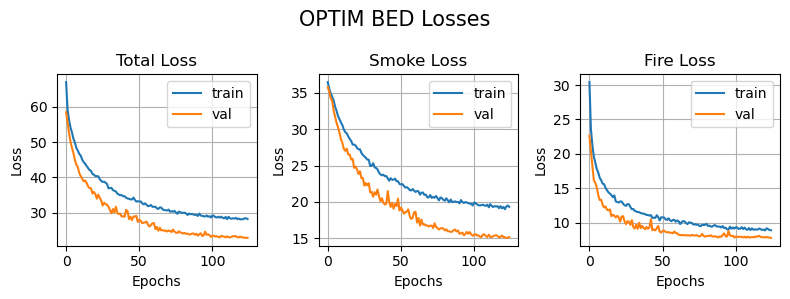

In [20]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()